In [11]:
%cd /content/drive/MyDrive/tensorflow


/content/drive/MyDrive/tensorflow


In [13]:
!git clone https://github.com/tensorflow/models.git


Cloning into 'models'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 47887 (delta 10), reused 22 (delta 2), pack-reused 47853
Receiving objects: 100% (47887/47887), 551.99 MiB | 18.98 MiB/s, done.
Resolving deltas: 100% (32978/32978), done.
Checking out files: 100% (2165/2165), done.


In [14]:
!apt-get install protobuf-compiler python-lxml python-pil
!pip install Cython pandas tf-slim

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 14 not upgraded.
Need to get 1,791 kB of archives.
After this operation, 7,807 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-pkg-resources all 39.0.1-2 [128 kB]
Get:3 http:/

In [21]:
# Install the Object Detection API
%%bash
cd /content/drive/MyDrive/tensorflow/models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/drive/My Drive/tensorflow/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=20182855 sha256=8d8fba6d156bac103c993e3855c80207969bb4c4d7cb1843de5ce49d5628ba0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-aweeo3im/wheels/87/67/67/459749afe66a3b9bcc6c557a5b81d0405c5431a0043a15a703
  Created wheel for avro-python3: filename=avro_python3-1.10.0-cp36-none-any.whl size=43735 sha256=080e4cc423b1b2a6c41dcb1a81307b13553057f31e0f894f08d2ea40d62a2b68
  Stored in directory: /root/.cache/pip/wheels/3f/15/cd/fe4ec8b88c130393464703ee8111e2cddebdc40e1b59ea85e9
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=a31eef6939a4f97719191b66944d5bacbcb4eaa04400135985450571bc79c4fe
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78532 sha256=a5a359855855d1cae93372340

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.25.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1; python_version >= "3.0", but you'll have avro-python3 1.10.0 which is incompatible.


In [23]:
!python /content/drive/MyDrive/tensorflow/models/research/object_detection/builders/model_builder_tf2_test.py


2020-12-02 08:24:52.185820: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2020-12-02 08:24:54.258875: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-02 08:24:54.318036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-02 08:24:54.318664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-12-02 08:24:54.318726: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully o

In [25]:
%cd /content/drive/MyDrive/tensorflow/scripts/preprocessing


/content/drive/MyDrive/tensorflow/scripts/preprocessing


In [27]:
%%writefile generate_tfrecord.py


import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import tensorflow.compat.v1 as tf
from PIL import Image
from object_detection.utils import dataset_util, label_map_util
from collections import namedtuple

# Initiate argument parser
parser = argparse.ArgumentParser(
    description="Sample TensorFlow XML-to-TFRecord converter")
parser.add_argument("-x",
                    "--xml_dir",
                    help="Path to the folder where the input .xml files are stored.",
                    type=str)
parser.add_argument("-l",
                    "--labels_path",
                    help="Path to the labels (.pbtxt) file.", type=str)
parser.add_argument("-o",
                    "--output_path",
                    help="Path of output TFRecord (.record) file.", type=str)
parser.add_argument("-i",
                    "--image_dir",
                    help="Path to the folder where the input image files are stored. "
                         "Defaults to the same directory as XML_DIR.",
                    type=str, default=None)
parser.add_argument("-c",
                    "--csv_path",
                    help="Path of output .csv file. If none provided, then no file will be "
                         "written.",
                    type=str, default=None)

args = parser.parse_args()

if args.image_dir is None:
    args.image_dir = args.xml_dir

label_map = label_map_util.load_labelmap(args.labels_path)
label_map_dict = label_map_util.get_label_map_dict(label_map)


def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def class_text_to_int(row_label):
    return label_map_dict[row_label]


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):

    writer = tf.python_io.TFRecordWriter(args.output_path)
    path = os.path.join(args.image_dir)
    examples = xml_to_csv(args.xml_dir)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
    writer.close()
    print('Successfully created the TFRecord file: {}'.format(args.output_path))
    if args.csv_path is not None:
        examples.to_csv(args.csv_path, index=None)
        print('Successfully created the CSV file: {}'.format(args.csv_path))


if __name__ == '__main__':
    tf.app.run()

Writing generate_tfrecord.py


In [28]:
!python generate_tfrecord.py -x /content/drive/MyDrive/tensorflow/training_demo/images/train \
                -l /content/drive/MyDrive/tensorflow/training_demo/annotations/object_detection.pbtxt \
                 -o /content/drive/MyDrive/tensorflow/training_demo/annotations/train.record


Successfully created the TFRecord file: /content/drive/MyDrive/tensorflow/training_demo/annotations/train.record


In [29]:
!python generate_tfrecord.py -x /content/drive/MyDrive/tensorflow/training_demo/images/test \
                -l /content/drive/MyDrive/tensorflow/training_demo/annotations/object_detection.pbtxt \
                 -o /content/drive/MyDrive/tensorflow/training_demo/annotations/test.record


Successfully created the TFRecord file: /content/drive/MyDrive/tensorflow/training_demo/annotations/test.record


In [30]:
%cd /content/drive/MyDrive/tensorflow/training_demo/
!mkdir pre-trained-models/


/content/drive/MyDrive/tensorflow/training_demo


In [34]:
!cd pre-trained-models && \
        curl http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz\
            > ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  233M  100  233M    0     0  92.4M      0  0:00:02  0:00:02 --:--:-- 92.4M


In [35]:
!cd pre-trained-models && tar -xzvf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/saved_model.pb
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/assets/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.index


In [53]:
!rm -rf models

In [54]:
!mkdir models/ && cd models && mkdir ssd_resnet50_v1_fpn_640x640
# !cp pre-trained-models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config models/ssd_resnet50_v1_fpn_640x640

In [59]:
%%writefile models/ssd_resnet50_v1_fpn_640x640/pipeline.config

model {
  ssd {
    num_classes: 1 # Set this to the number of different label classes
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_resnet50_v1_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 0.00039999998989515007
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.029999999329447746
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 0.00039999998989515007
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.009999999776482582
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.996999979019165
            scale: true
            epsilon: 0.0010000000474974513
          }
        }
        depth: 256
        num_layers_before_predictor: 4
        kernel_size: 3
        class_prediction_bias_init: -4.599999904632568
      }
    }
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        scales_per_octave: 2
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 9.99999993922529e-09
        iou_threshold: 0.6000000238418579
        max_detections_per_class: 100
        max_total_detections: 100
        use_static_shapes: false
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 2.0
          alpha: 0.25
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
  }
}
train_config {
  batch_size: 2 # Increase/Decrease this value depending on the available memory (Higher values require more memory and vice-versa)
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_crop_image {
      min_object_covered: 0.0
      min_aspect_ratio: 0.75
      max_aspect_ratio: 3.0
      min_area: 0.75
      max_area: 1.0
      overlap_thresh: 0.0
    }
  }
  sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.03999999910593033
          total_steps: 2000
          warmup_learning_rate: 0.013333000242710114
          warmup_steps: 200
        }
      }
      momentum_optimizer_value: 0.8999999761581421
    }
    use_moving_average: false
  }
  fine_tune_checkpoint: "pre-trained-models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0" # Path to checkpoint of pre-trained model
  num_steps: 2000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 1
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "detection" # Set this to "detection" since we want to be training the full detection model
  use_bfloat16: false # Set this to false if you are not training on a TPU
  fine_tune_checkpoint_version: V2
}
train_input_reader {
  label_map_path: "annotations/object_detection.pbtxt" # Path to label map file
  tf_record_input_reader {
    input_path: "annotations/train.record" # Path to training TFRecord file
  }
}
eval_config {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: "annotations/object_detection.pbtxt" # Path to label map file
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "annotations/test.record" # Path to testing TFRecord
  }
}

Overwriting models/ssd_resnet50_v1_fpn_640x640/pipeline.config


In [57]:
!cp ../models/research/object_detection/model_main_tf2.py .

In [60]:
!python model_main_tf2.py --model_dir=models/ssd_resnet50_v1_fpn_640x640 --pipeline_config_path=models/ssd_resnet50_v1_fpn_640x640/pipeline.config


2020-12-02 09:30:32.773846: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-02 09:30:34.715686: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-02 09:30:34.751593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-02 09:30:34.752209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-12-02 09:30:34.752254: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-02 09:30:34.754294: I tensorflow/stream_executor/platform/default

## Inference

In [68]:
PATH_TO_MODEL_DIR = '/content/drive/MyDrive/tensorflow/training_demo/models/ssd_resnet50_v1_fpn_640x640'
PATH_TO_LABELS = '/content/drive/MyDrive/tensorflow/training_demo/annotations/object_detection.pbtxt'

In [66]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + ""

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-4')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))


Loading model... 

In [69]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [84]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import glob
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

def display_inference(images_paths):
    for image_path in glob.glob(f"{images_paths}/*"):

        print('Running inference for {}... '.format(image_path), end='')

        image_np = load_image_into_numpy_array(image_path)

        # Things to try:
        # Flip horizontally
        # image_np = np.fliplr(image_np).copy()

        # Convert image to grayscale
        # image_np = np.tile(
        #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

        detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                    for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=.30,
                agnostic_mode=False)

        plt.figure()
        plt.imshow(image_np_with_detections)
        print('Done')
    plt.show()

# sphinx_gallery_thumbnail_number = 2

Running inference for images_test/0571.jpg... Done
Running inference for images_test/6.jpg... Done
Running inference for images_test/10.jpg... Done


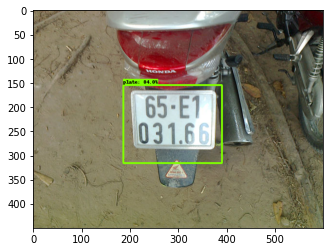

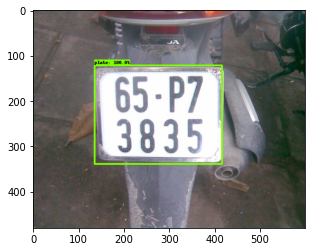

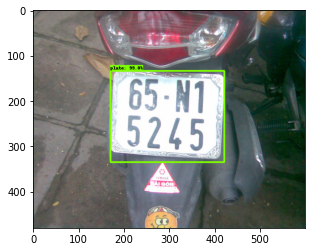

In [85]:
display_inference('images_test')